In [ ]:
!pip install tensorflow tensorflow-gpu pandas matplotlib sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 588.3 MB 22 kB/s 
     |████████████████████████████████| 578.1 MB 8.0 kB/s 
     |████████████████████████████████| 578.1 MB 7.0 kB/s 
     |████████████████████████████████| 511.8 MB 27 kB/s 
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=acb494ed281f62ae9259cf267d3eb32744be2829c74aeddf884b7c547378ff32
  Stored in directory: /root/.cache/pip/wheels/14/25/f7/1cc0956978ae479e75140219088deb7a36f60459df242b1a72
Successfully built sklearn


In [ ]:
import os
import pandas as pd 
import tensorflow as tf
import numpy as np 

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
df = pd.read_csv('/content/drive/MyDrive/data/train.csv')

In [8]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [9]:
df.iloc[1]['comment_text']

"D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)"

### Feature Extraction

In [11]:
from tensorflow.keras.layers import TextVectorization

In [12]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [13]:

MAX_FEATURES = 200000  # number of words in teh vocab 

In [14]:

vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                              output_sequence_length=1800, # sentence length in total
                              output_mode='int')

In [15]:
vectorizer.adapt(X.values)

In [16]:
vectorized_text = vectorizer(X.values)

In [17]:
#MCSHBAP - map, cache, shuffle, batch, prefetch 
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) #helps prevent bottomnecks

In [18]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

## Create Sequention Model

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [20]:
model = Sequential()
# Create the embedding layer
model.add(Embedding(MAX_FEATURES+1, 32))
#Biderectional LSTM layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected Layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final Layer
model.add(Dense(6, activation='sigmoid'))

In [21]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [26]:
history = model.fit(train, epochs=10, validation_data=val)

Epoch 1/10
6981/6981 [==============================] - 602s 86ms/step - loss: 0.0453 - val_loss: 0.0391
Epoch 2/10
6981/6981 [==============================] - 604s 86ms/step - loss: 0.0408 - val_loss: 0.0392
Epoch 3/10
6981/6981 [==============================] - 614s 88ms/step - loss: 0.0364 - val_loss: 0.0329
Epoch 4/10
6981/6981 [==============================] - 602s 86ms/step - loss: 0.0326 - val_loss: 0.0285
Epoch 5/10
6981/6981 [==============================] - 603s 86ms/step - loss: 0.0297 - val_loss: 0.0246
Epoch 6/10
6981/6981 [==============================] - 603s 86ms/step - loss: 0.0265 - val_loss: 0.0235
Epoch 7/10
6981/6981 [==============================] - 601s 86ms/step - loss: 0.0242 - val_loss: 0.0205
Epoch 8/10
6981/6981 [==============================] - 601s 86ms/step - loss: 0.0222 - val_loss: 0.0183
Epoch 9/10
6981/6981 [==============================] - 604s 86ms/step - loss: 0.0202 - val_loss: 0.0173
Epoch 10/10
6981/6981 [==============================] 

In [27]:
from matplotlib import pyplot as plt

<Figure size 576x360 with 0 Axes>

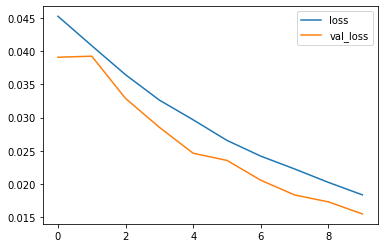

In [28]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

### Make Predictions

In [29]:
input_text = vectorizer('Shut up you idiot! I will kill you')

In [31]:
batch = test.as_numpy_iterator().next()

In [36]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [40]:
batch_y

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [39]:
(model.predict(batch_X) > 0.5).astype(int)

1/1 [==============================] - 0s 65ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [35]:
res = model.predict(np.expand_dims(input_text,0))

1/1 [==============================] - 0s 60ms/step


### Evaluation

In [42]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [43]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [44]:
for batch in test.as_numpy_iterator(): 
  #Unpack the batch 
  X_true, y_true = batch 
  yhat = model.predict(X_true)

  y_true = y_true.flatten()
  yhat = yhat.flatten()

  pre.update_state(y_true, yhat)
  re.update_state(y_true, yhat)
  acc.update_state(y_true, yhat)

1/1 [==============================] - 0s 54ms/step


In [45]:
print(f'Precision: {pre.result().numpy()},Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.9290472269058228, Recall:0.9157864451408386, Accuracy:0.5125375986099243


### Test and Gradio

In [47]:
!pip install gradio jinja2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.8 MB 31.3 MB/s 
     |████████████████████████████████| 106 kB 76.6 MB/s 
     |████████████████████████████████| 2.3 MB 63.8 MB/s 
     |████████████████████████████████| 55 kB 4.9 MB/s 
     |████████████████████████████████| 278 kB 79.9 MB/s 
     |████████████████████████████████| 84 kB 4.0 MB/s 
     |████████████████████████████████| 56 kB 6.0 MB/s 
     |████████████████████████████████| 84 kB 4.2 MB/s 
     |████████████████████████████████| 64 kB 3.4 MB/s 
     |████████████████████████████████| 80 kB 11.7 MB/s 
     |████████████████████████████████| 68 kB 8.5 MB/s 
     |████████████████████████████████| 58 kB 6.7 MB/s 
     |████████████████████████████████| 50 kB 8.0 MB/s 
  Created wheel for ffmpy: filename=ffmpy-0.3.0-py3-none-any.whl size=4711 sha256=551283262bd3bc5a8ce7f9494a4c0a73566dfa6f0b015dd145e64062adafc263
  Stored in dire

In [48]:
import gradio as gr

In [50]:
model.save("toxicity.h5")

In [51]:
model = tf.keras.models.load_model('toxicity.h5')

In [55]:
input = vectorizer("You're a good boy")

In [56]:
res = model.predict(np.expand_dims(input,0))

1/1 [==============================] - 0s 59ms/step


In [57]:
res

array([[1.4725707e-02, 2.9917377e-10, 8.9820969e-04, 7.1606279e-05,
        1.3747580e-03, 9.2848408e-05]], dtype=float32)

In [59]:
def score_comment(comment):
  vectorized_comment = vectorizer([comment])
  results = model.predict(vectorized_comment)

  text = ''
  for idx, col in enumerate(df.columns[2:]):
    text += '{}: {}\n'.format(col, results[0][idx]>0.5)

  return text

In [62]:
interface = gr.Interface(fn=score_comment, 
                         inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),
                        outputs='text')

In [63]:
interface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`

Setting up a public link... we have recently upgraded the way public links are generated. If you encounter any problems, please report the issue and downgrade to gradio version 3.13.0
.
Running on public URL: https://c514a353-7a2d-4cff.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces
